In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class KArmedBandit(gym.Env):
    
    def __init__(self, k, generators):
        if len(generators) != k:
            raise ValueError(f"expected {k} generators but got {len(generators)}")
        self.action_space = gym.spaces.Discrete(k)
        self.observation_space = None
        self.generators = generators
    
    def step(self, action):
        if action not in self.action_space:
            k = self.action_space.n
            raise ValueError(f"invalid action {action}; expected one in {{0, ..., {k - 1}}}")
        return None, self.generators[action](), False, {}
    
    def reset(self):
        return None
    
    def render(self, mode=None):
        pass


<Figure size 432x288 with 0 Axes>

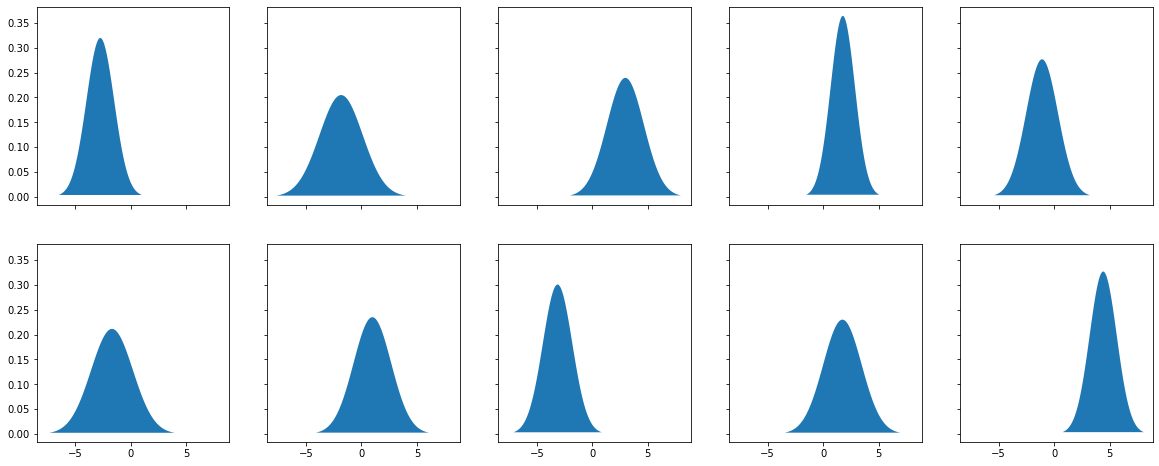

In [3]:
SEED = 12345


class NormalDistribution:
    
    def __init__(self, rng=None, mu=0, sigma=1):
        self.rng = np.random.default_rng() if rng is None else rng
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, x=None):
        if x is None:
            return self.rng.normal(self.mu, self.sigma)
        return 1 / (self.sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - self.mu) ** 2 / (2 * self.sigma ** 2))
    
    def plot(self, ax=None, ticks=1000):
        if ax is None:
            ax = plt
        stds = 3 * self.sigma
        x = np.linspace(self.mu - stds, self.mu + stds, ticks)
        y = self(x)
        ax.fill(x, y)
    

rng = np.random.default_rng(SEED)
k = 10
# Normal distributions with mean in [-5, 5] and std in [1, 2]
mus = rng.uniform(-5, 5, k)
sigmas = rng.uniform(1, 2, k)
generators = [
    NormalDistribution(rng, mu, sigma)
    for mu, sigma in zip(mus, sigmas)
]

plt.figure()
_, axs = plt.subplots(2, 5, figsize=(20, 8), sharex='all', sharey='all')
for gen, ax in zip(generators, axs.flatten()):
    gen.plot(ax)
plt.show()

In [4]:
env = KArmedBandit(k, generators)

In [5]:
def ucb_score(c, t, Q, N):
    zeros = N == 0
    if zeros.any():
        return np.arange(len(Q))[zeros][0]
    return np.argmax(Q + c * np.sqrt(np.log(t) / N))

def eps_greedy(eps, rng, Q):
    if rng.uniform(0, 1) < eps:
        return rng.choice(len(Q))
    return np.argmax(Q)

In [6]:
T = 1000
steps = list(range(1, T + 1))

In [7]:
ucb_rewards = []
cummulative = 0

Q_ucb = np.zeros(k)
N_ucb = np.zeros(k)
V_ucb = np.zeros(k)

for t in steps:
    action = ucb_score(2, t, Q_ucb, N_ucb)
    _, reward, _, _ = env.step(action)
    N_ucb[action] += 1
    V_ucb[action] += reward
    Q_ucb[action] = V_ucb[action] / N_ucb[action]
    cummulative += reward
    ucb_rewards.append(cummulative / t)

cummulative

4357.392167678252

In [8]:
eps_greedy_rewards = []
cummulative = 0

Q_eps = np.zeros(k)
N_eps = np.zeros(k)
V_eps = np.zeros(k)

for t in steps:
    action = eps_greedy(.1, rng, Q_eps)
    _, reward, _, _ = env.step(action)
    N_eps[action] += 1
    V_eps[action] += reward
    Q_eps[action] = V_eps[action] / N_eps[action]
    cummulative += reward
    eps_greedy_rewards.append(cummulative / t)

cummulative

3974.54773672494

In [9]:
best_expected_reward = mus.max()

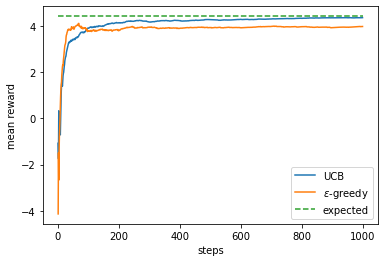

In [10]:
plt.plot(steps, ucb_rewards)
plt.plot(steps, eps_greedy_rewards)
plt.plot([steps[0], steps[-1]], [best_expected_reward] * 2, '--')
plt.legend(['UCB', r'$\varepsilon$-greedy', 'expected'])
plt.xlabel('steps')
plt.ylabel('mean reward')
plt.show()

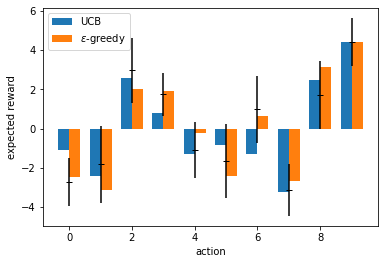

In [11]:
width = .35
x = np.arange(10)

plt.bar(x - width / 2, Q_ucb, width=width, align='center')
plt.bar(x + width / 2, Q_eps, width=width, align='center')
plt.legend(['UCB', r'$\varepsilon$-greedy'])
plt.xlabel('action')
plt.ylabel('expected reward')

plt.errorbar(x, mus, sigmas, fmt='k_')
plt.show()

In [12]:
N_ucb

array([  1.,   1.,   8.,   2.,   1.,   1.,   1.,   1.,   8., 976.])

In [13]:
N_eps

array([ 10.,  10.,  14.,  13.,   3.,  11.,   8.,  16.,   8., 907.])